# Diễn giải mô hình Machine learning bằng SHAP 
# Bài toán phân loại nhiều nhãn

### BS. Lê Ngọc Khả Nhi

# Giới thiệu

Việc áp dụng những phương pháp diễn giải mô hình Machine learning hiện đại như LIME và SHAP cho phép chúng ta vận dụng những algorithm khác hơn ngoài hồi quy tuyến tính (logistic), đặc biệt cho những bài toán phức tạp như dữ liệu đa chiều (rất nhiều features, kết quả có nhiều nhãn).

Trong bài hôm nay, Nhi sẽ trình diễn những tính năng của phương pháp diễn giải mô hình SHAP (SHapley Additive exPlanations) cho phép khảo sát về vai trò đóng góp của mỗi input features trong một bài toán phân loại 3 nhãn (multiclass classification) thông qua một mô hình Random Forest.

Trong thí nghiệm này, Nhi sử dụng bộ dữ liệu "vertebra-column". Thông tin về cấu trúc dữ liệu và bài toán (nguồn: thư viện openML https://www.openml.org/d/1523)

Tóm tắt về bài toán:

Chúng ta có dữ liệu gồm 6 input features đều là biến số liên tục, theo thứ tự từ V1 đến V6: pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis.

Mục tiêu gốc của bài toán là phân loại bệnh nhân thành 3 phân nhóm: (Class) : Normal (mã giá trị = 2, 100 ca), Disk Hernia (mã giá trị = 1, 60 ca) hay Spondylolisthesis (mã giá trị = 3, 150 ca).

Mục tiêu của thí nghiệm: Khảo sát vai trò đóng góp của mỗi feature vào kết quả chẩn đoán phân biệt 3 phân nhóm như trên.

In [60]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

#LOOCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

# RF
from sklearn.ensemble import RandomForestClassifier

# Confusion matrix
import itertools
from itertools import cycle
from numpy import where

# SHAP
import shap
shap.initjs()

# Thí nghiệm Machine learning

## Bước 1: Chuẩn bị dữ liệu

In [375]:
df = pd.read_csv('https://www.openml.org/data/get_csv/1593719/phpOkU53r.csv')

feat_names = ['pelvic_incidence', 
                 'pelvic_tilt', 
                 'lumbar_lordosis_angle', 
                 'sacral_slope', 
                 'pelvic_radius', 
                 'spondylolisthesis_grade']

labs = ['Disk_Hernia','Normal','Spondylolisthesis']

lab_dict = {k:v for k,v in zip([1,2,3], labs)}

df

,V1,V2,V3,V4,V5,V6,Class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985136,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,2
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,2
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,2
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,2


In [405]:
df.shape

(310, 7)

# Bước 2: Thăm dò dữ liệu

## Mô tả 6 features V1-V6 giữa 3 phân nhóm

In [404]:
df.groupby('Class').describe(percentiles = [0.05,0.5,0.95]).T

Class              1           2           3
V1 count   60.000000  100.000000  150.000000
   mean    47.638407   51.685244   71.514224
   std     10.697131   12.368161   15.109337
   min     26.147921   30.741938   37.903910
   5%      31.273831   34.636541   45.152469
   50%     46.416169   50.123116   72.149306
   95%     66.976851   73.036113   91.775403
   max     74.433593   89.834676  129.834041
V2 count   60.000000  100.000000  150.000000
   mean    17.398795   12.821414   20.748038
   std      7.016708    6.778503   11.506169
   min      3.144669   -5.845994   -6.554948
   5%       7.443564    1.040521    4.833054
   50%     16.949285   13.482435   19.309548
   95%     28.893082   22.717116   40.844162
   max     41.557331   29.894119   49.431864
V3 count   60.000000  100.000000  150.000000
   mean    35.463524   43.542605   64.110108
   std      9.767795   12.361388   16.397068
   min     14.000000   19.071075   24.710274
   5%      19.808860   26.199988   40.888184
   50%     35.164873   42.638923   62.555200
   95%     50.287584   63.167549   91.762129
   max     62.275275   90.563461  125.742386
V4 count   60.000000  100.000000  150.000000
   mean    30.239612   38.863830   50.766186
   std      7.555388    9.624004   12.318813
   min     13.366931   17.386972   19.290046
   5%      16.216618   23.410802   33.675218
   50%     30.000659   37.059694   50.751695
   95%     42.061476   53.495395   67.177487
   max     46.613539   67.195460  121.429566
V5 count   60.000000  100.000000  150.000000
   mean   116.474968  123.890834  114.518810
   std      9.355720    9.014246   15.579995
   min     84.241415  100.501192   70.082575
   5%      98.769465  110.482398   89.934854
   50%    116.696146  123.874328  114.842400
   95%    130.424714  139.152371  141.040252
   max    137.540613  147.894637  163.071041
V6 count   60.000000  100.000000  150.000000
   mean     2.480251    2.186572   51.896687
   std      5.531177    6.307483   40.108030
   min    -10.675871  -11.058179    1.010041
   5%      -7.913149   -5.147777   20.672078
   50%      2.542441    1.152710   42.372510
   95%     11.224108   12.447626  103.446177
   max     15.779697   31.172767  418.543082

## Phân bố của 6 features trong 3 phân nhóm

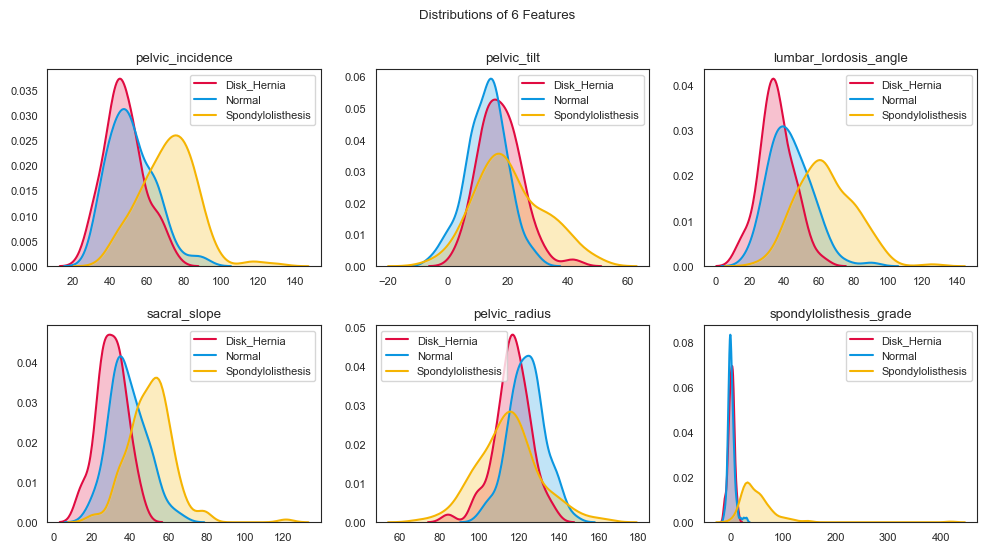

In [391]:
sns.set_palette(sns.color_palette(['#e00b41','#0b96e0','#f5b402']))

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams.update({'font.size': 8})

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Distributions of 6 Features')

for ax,feature,name in zip(axes.flatten(), 
                           list(df.drop(['Class'], axis = 1).columns),
                           feat_names):
    ax.set(title=name)
    for i in range(len((labs))):
        sns.kdeplot(data = df[df['Class'] == i+1][feature].values,
                    label = lab_dict[i+1],
                    shade = True,
                    ax = ax)

## Bước 3: Suy diễn thống kê bằng SHAP

Mục tiêu của bài toán này khá thường gặp trong nghiên cứu Y học. Thông thường nó được giải quyết theo 2 cách: phân tích đơn biến sử dụng ANOVA, hoặc phân tích đa biến thông qua một mô hình hồi quy multinomial logistic.

Tuy nhiên trong thí nghiệm này, Nhi sẽ làm khác hơn:

1) Thay vì sử dụng mô hình tuyến tính, đầu tiên Nhi dựng 1 mô hình Random Forest (multiclass classifier)

2) Sau đó áp dụng phương pháp SHAP để diễn giải mô hình RF này

Trước hết, ta đặt ra một cấu trúc mô hình Random Forest với 500 cây quyết định, max-depth = 5:

In [118]:
rf_mod = RandomForestClassifier(n_estimators = 500, 
                                max_depth = 5, 
                                criterion = 'gini',
                                n_jobs = -1,
                                random_state = 123)

Nhi sẽ thực hiện một quy trình Leave one out cross-validation. Quy trình này sẽ lần lượt dựng 309 phiên bản mô hình RF khác nhau trên dữ liệu gồm (n-1) trường hợp và áp dụng mô hình này cho 1 trường hợp duy nhất được tách riêng ra từ dữ liệu gốc (n=310). Nếu kết quả dự báo đúng, điểm Accuracy = 1, ngược lại = 0. Ta có thể tính được điểm accuracy trung bình = 0.835

In [90]:
data = df.values
X, y = data[:, :-1], data[:, -1]

In [93]:
cv = LeaveOneOut()

In [121]:
scores = cross_val_score(rf_mod, 
                         X, y,
                         scoring='accuracy', 
                         cv=cv, 
                         n_jobs=-1)

scores.mean()

0.8354838709677419

Tiếp theo, Nhi dựnng một mô hình RF trên toàn bộ dữ liệu:

In [122]:
rf_mod.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Sau khi có mô hình, Nhi áp dụng SHAP. 

Nhắc lại về cơ chế hoạt động: Quy trình SHAP sẽ lần lượt cho mỗi feature kết hợp ngẫu nhiên với những features khác để tạo thành 1 đội và hợp sức tạo ra kết quả cho 1 trường hợp, mỗi feature (người chơi) sẽ được thưởng 1 số điểm tùy theo thành tích đóng góp vào kết quả chung của toàn đội. Cuối cùng, ta tính được điểm số SHAP cho 1 feature xác định, là kết quả trung bình của tất cả lượng thay đổi trên kết quả dự báo mà 1 đội đạt được, khi feature đó tham gia vào đội.
    
Phương pháp này được áp dụng vào Python qua package shap: https://github.com/slundberg/shap

Quy trình diễn giải mô hình bắt đầu bằng việc tạo ra 1 explainer object. shap cung cấp nhiều algorithm explainer khác nhau nhưng ở đây do ta dùng mô hình cây (Random Forest là mô hình cây tập hợp), nên Nhi chọn dùng TreeExplainer.

Sau khi có explainer object, ta áp dụng cho features (tập X) để sinh ra tập giá trị shap_values,

expected_value là một thuộc tính trong explainer, nó cho biết prediction score cơ bản cho mỗi nhãn giá trị). 

In [202]:
explainer = shap.TreeExplainer(rf_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

shap_values là 1 array lưu trữ shap score cho 6 feature tương ứng với mỗi trường hợp quan sát.

Chú ý: Khi áp dụng shap cho một bài toán nhiều (k) lớp (multiclass), shap_values sẽ là 1 array (k x n) chiều với n = số quan sát, k là số lượng label cần dự báo. Tương tự, expected_value là 1 list gồm k giá trị prediction score cơ bản tương ứng với k nhãn.

Như vậy, shap value cho phép diễn giải riêng biệt cho kết quả phân loại của từng nhãn, thí dụ trong bài toán này nhãn y=2 tương ứng với class "Normal", nếu kết quả dự báo :Y_normal cao hơn 0.5 thì xem như Positive, thấp hơn 0.5 xem như negative. Khi dùng shap, ta cắt bài toán multiclass thành 3 bài toán nhị phân (One vs Rest). Cần lưu ý điều này trong quá trình giải nghĩa mô hình.

## Biểu đồ Variable importance

Dạng biểu đồ này cho phép ta khảo sát vai trò của các features, hay khả năng đóng góp của chúng vào kết quả phân loại của 1 nhãn chuyên biệt.

Biểu đồ này được dựng qua hàm summary_plot. Cấu tạo của biểu đồ như sau:

Trục X là thang đo shap score,

Trục Y là danh sách các features, được xếp thứ hạng tùy vào tầm quan trọng, cao nhất là feature quan trọng nhất.

Một yếu tố hình họa (điểm, cột, violin, có thể tùy chỉnh) cho phép khảo sát phân bố của shap score cho mỗi feature, và so sánh chúng.

Giá trị mỗi feature được chuẩn hóa về 1 thang đo biểu kiến, được trình bày trên phổ màu bên phải. Người dùng có thể tùy chỉnh phổ màu này theo ý thích.

Thí dụ kết quả cho class Normal (index 1 trong label list):

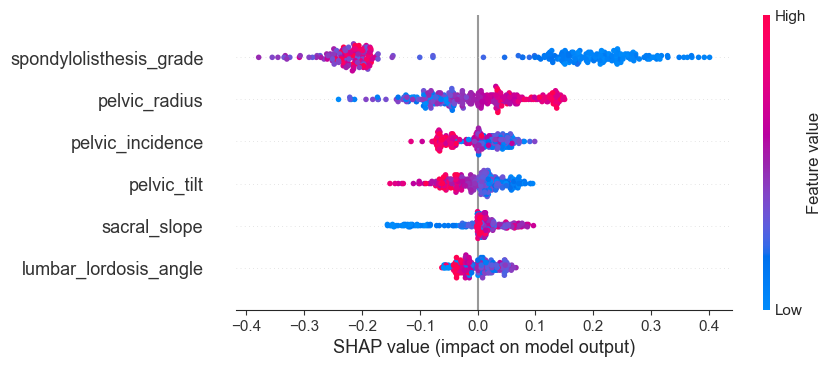

In [223]:
plt.rcParams['figure.figsize'] = [4,6]
plt.rcParams['figure.dpi']= 100

# Normal
shap.summary_plot(shap_values[1], # Class Normal (index 1 trong label list)
                  X, 
                  feature_names = feat_names,
                  plot_type = "dot",
                  show = True,
                  sort = True,
                  auto_size_plot= True)

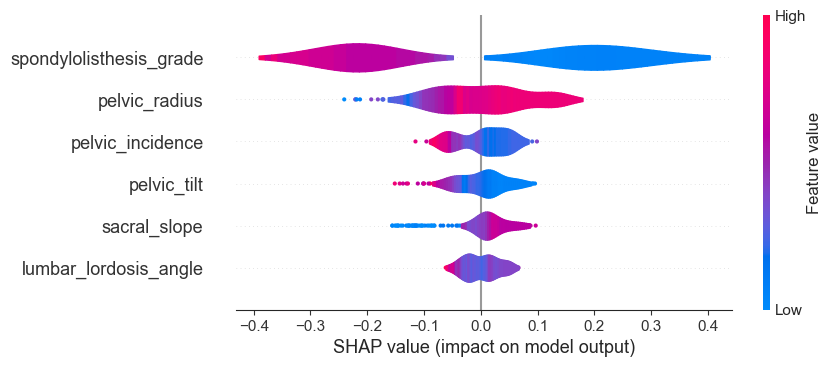

In [326]:
shap.summary_plot(shap_values[1], 
                  X, 
                  feature_names = feat_names,
                  plot_type = "violin",
                  show = True,
                  sort = True,
                  auto_size_plot= True)

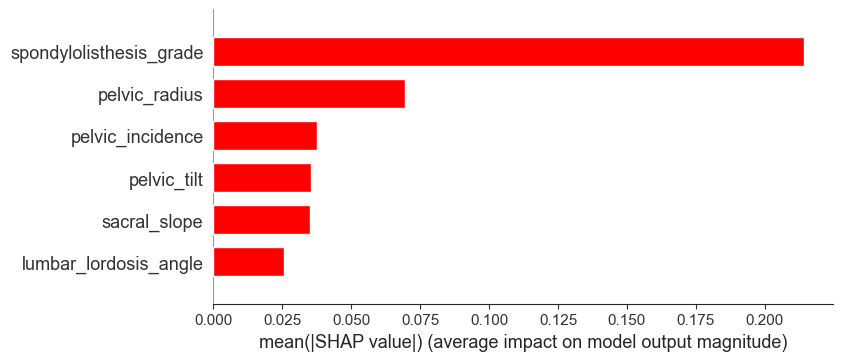

In [341]:
shap.summary_plot(shap_values[1], 
                  X, 
                  feature_names = feat_names,
                  plot_type = "bar",
                  color = 'red',
                  show = True,
                  sort = True,
                  auto_size_plot= True)

Riêng cho dạng biểu đồ thanh (cột), cho phép biểu diễn đồng thời cho 3 mục tiêu trong bài toán Multiclass (ở đây là 3 class). Mỗi class sẽ được tô 1 màu khác nhau, và có thể tùy chỉnh bằng 1 phổ màu không liên tục của matplotlib.

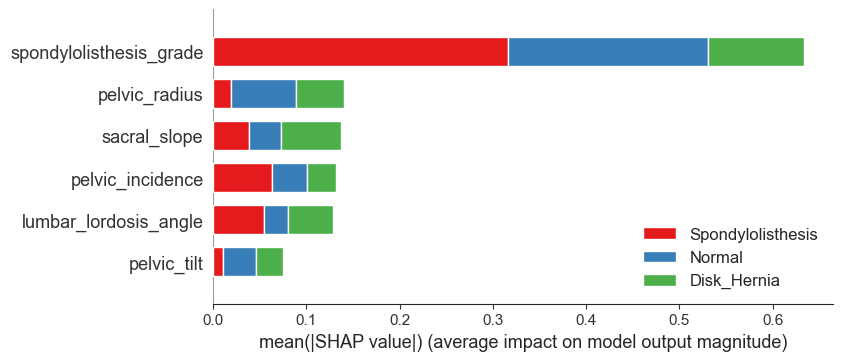

In [221]:
shap.summary_plot(shap_values, 
                  X, 
                  feature_names = feat_names,
                  plot_type = "bar",
                  show = True,
                  sort = True,
                  auto_size_plot= True,
                  class_names=labs,
                  color = cm.Set1,)

# Biểu đồ Decision plot

Decision plot là một biểu đồ rất thú vị, vì nó cho phép giải thích kết quả của mô hình cho cả cấp độ quần thể hay từng cá thể một cách trực quan và dễ hiểu. 

Lưu ý là khi áp dụng cho bài toán multiclass, decision plot sẽ chuyên biệt cho 1 nhãn nhất định, tùy theo index trong label list, thí dụ ở đây ta khảo sát riêng cho class Normal, ta có bài toán nhị phân : Normal hoặc Không phải Normal.

Cấu trúc biểu đồ như sau:

Trục X biểu thị thang đo của kết quả dự báo (ở đây: xác suất 0:1 cho chẩn đoán xác định nhãn Normal hoặc nói cách khác, sữ loại trừ 2 bệnh lý).

Trục Y trình bày danh sách các features, sắp xếp theo mức độ đóng góp/tầm quan trọng. feature càng quan trọng được xếp trên, feature dóng góp yếu hơn ở dưới.

Một phổ màu liên tục trình bày kết quả dự báo, nằm phía trên biểu đồ, mỗi giá trị được mã hóa 1 màu khác nhau và người dùng có thể tùy chỉnh phổ màu này theo ý thích.

Yếu tố hình họa là 1 biểu đồ tuyến kí, mang lại hình ảnh 1 con đường, dẫn từ vị trí của base value của hàm f(X), lúc chưa có 1 feature nào tham gia, sau đó mỗi bước đi trên con đường này ta đưa 1 feature tham gia vào mô hình, từ yếu đến mạnh. Mỗi feature sẽ kéo ta đi về bên trái hay phải thang đo của outcome, tùy theo liên hệ giữa outcome và feature đó, lực kéo cũng mạnh hay yếu khác nhau. feature càng quan trọng kéo càng mạnh, dẫn ta đi càng xa. Cuối cùng, feature mạnh nhất quyết định sẽ dẫn ta đến 1 vị trí trên thang đo outcome, chính là kết quả dự báo sau cùng.

Khi diễn giải cho cá thể, chỉ có 1 con đường được vẽ, và được dán label kèm theo là giá trị mỗi feature, khi áp dụng cho quần thể, nhiều con đường chồng lên nhau và người dùng có thể thay đổi giá trị alpha để nhìn rõ hơn.

Lưu ý phải dùng link function là logit 

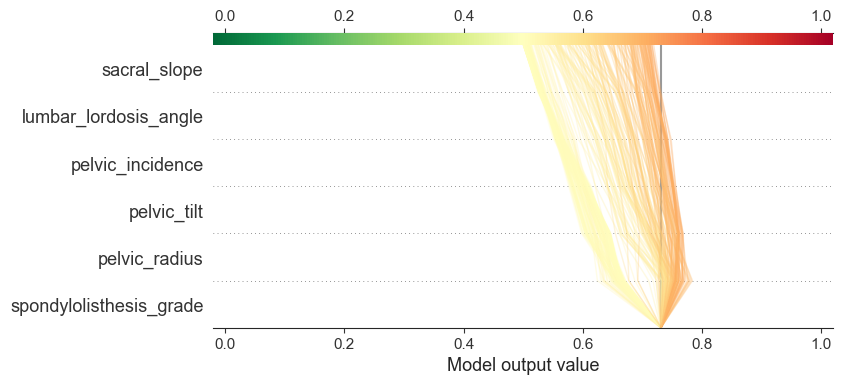

In [338]:
shap.decision_plot(base_value = expected_value[1], 
                   shap_values = shap_values[1], 
                   feature_order='hclust',
                   feature_names = feat_names,
                   features = X,
                   plot_color= cm.RdYlGn_r,
                   alpha = 0.3,
                   link='logit',
                  new_base_value = True)

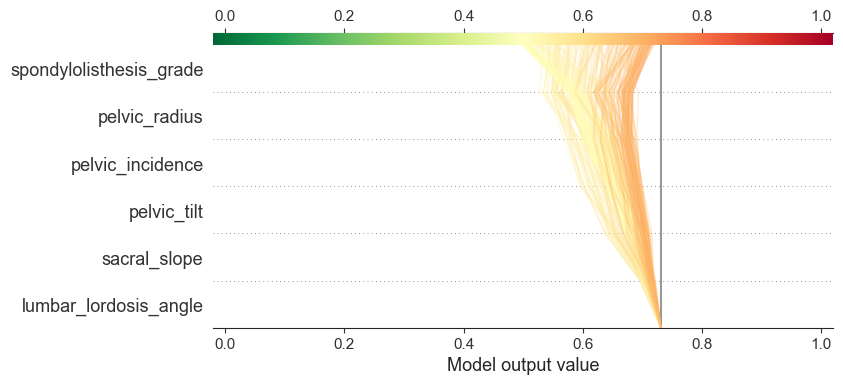

In [339]:
shap.decision_plot(base_value = expected_value[1], 
                   shap_values = shap_values[1], 
                   feature_order='importance',
                   feature_names = feat_names,
                   features = X,
                   plot_color= cm.RdYlGn_r,
                   alpha = 0.3,
                   link='logit',
                  new_base_value = True)

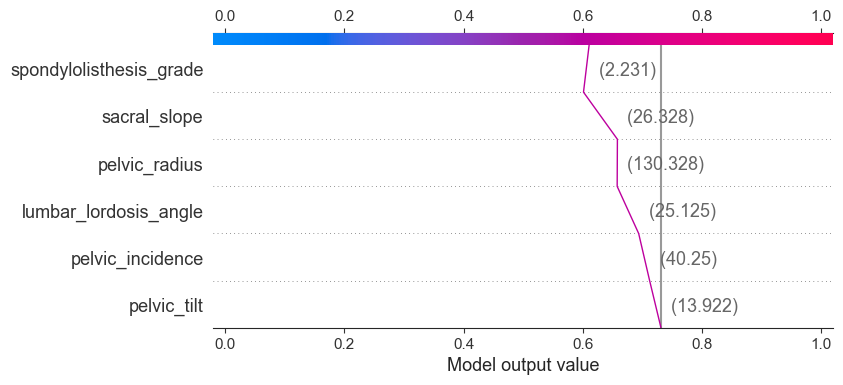

In [281]:
case = 5

shap.decision_plot(base_value = expected_value[1], 
                   shap_values = shap_values[1][case], 
                   feature_order='importance',
                   feature_names = feat_names,
                   features = X[case],
                   alpha = 1,
                   link='logit',
                  new_base_value = True)

## Biểu đồ waterfall

Tiếp theo, ta có biểu đồ waterfall dựng bằng hàm waterfall_plot, công dụng của biểu đồ này nhằm diễn giải kết quả dự báo mô hình cho từng cá thể, đồng thời đánh giá luôn mức độ đóng góp/tầm quan trọng của mỗi features cho riêng cá thể đó.

Cấu tạo của biểu đồ gồm:

Trục X hiển thị thang đo của hàm f(X) cho bài toán phân loại.

Trục Y sắp xếp features theo độ quan trọng, nhằm đánh giá khả năng đóng góp vào kết quả dự báo

Tương ứng với mỗi features là giá trị của features đó cho cá thể đang khảo sát

Yếu tố hình họa sử dụng biểu đồ thanh (cột), nhằm đo lường và so sánh độ đóng góp vào kết quả hàm f(X) cho mỗi features.

Feature càng quan trọng thì kích thước bar càng dài,

Trên mỗi bar được dán nhãn giá trị shap score, dấu +/- cho biết vai trò của features làm tăng hay giảm kết quả hàm f(X)

Ta có thể thấy mỗi feature đã đóng góp mạnh yếu khác nhau vào kết quả hàm f(X), khi đưa lần lượt từng features, từ yếu nhất đến mạnh nhất, giá trị f(X) sẽ tăng hoặc giảm cho đến khi đạt giá trị sau cùng chính là kết quả dự báo cho cá thể đó.

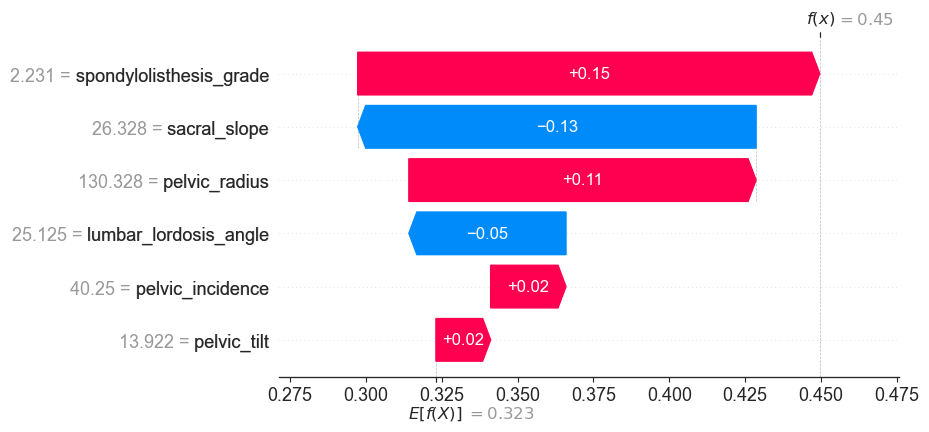

In [284]:
case = 5

shap.waterfall_plot(
    expected_value[1],
    shap_values[1][case],
    features=X[case],
    feature_names=feat_names,
    show=True)

## Biểu đồ force_plot

Biểu đồ force plot có ý nghĩa tương tự như decision plot, nhưng thay vì hình ảnh một cuộc dạo chơi trên con đường, với các bước đi rẽ trái, rẽ phải... thì ta có hình ảnh khác là 2 nhóm người chơi đang đẩy một vật với lực đẩy ngược chiều; tương ứng với hiệu quả của feature làm tăng, giảm kết quả dự báo.

Có thể hình dung đây là biểu đồ waterfall plot được nén ép lại.

Cấu tạo của biểu đồ rất đơn giản, nó chỉ có 1 chiều là thang đo của kết quả dự báo, lức đẩy của mổi feature được hiển thị bằng kích thước mũi tên, và mũi tên được tô màu theo chiều tăng/giảm. Chỉ có giá trị các features quan trọng nhất được thể hiện.

Tương tự waterfall plot và decision plot, force plot dùng để diễn giải ở cấp độ cá thể, và nó rất hiệu quả.

Lưu ý: cũng như waterfall và decision, force plot chỉ áp dụng cho từng nhãn chuyên biệt (One vs rest), ta định vị bằng index trong label list. Thí dụ index = 1 là nhãn Normal, Index = 0 là nhãn Disk_hernia...

In [297]:
case = 10

shap.force_plot(base_value = expected_value[1], 
                shap_values = shap_values[1][case],
                features =  X[case],
                feature_names = feat_names,
                out_names = labs,
                link = 'logit',
                figsize = (10,15))

In [304]:
case = 60

shap.force_plot(base_value = expected_value[2], 
                shap_values = shap_values[2][case],
                features =  X[case],
                feature_names = feat_names,
                out_names = labs,
                link = 'logit',
                figsize = (10,15))

In [316]:
case = 301

shap.force_plot(base_value = expected_value[2], 
                shap_values = shap_values[2][case],
                features =  X[case],
                feature_names = feat_names,
                out_names = labs,
                link = 'logit',
                figsize = (10,15))

Ta cũng có thể áp dụng forceplot cho quần thể, lúc này các mũi tên được thay bằng area plot, trục X biểu thị cho danh sách các trường hợp:

Đây là 1 biểu đồ tương tác, ta có thể chọn giá trị trên trục Y.

Công dụng của biểu đồ này để khảo sát tổng thể phân bố của shap score trong quần thể.

In [325]:
shap.force_plot(base_value = expected_value[1], 
                shap_values = shap_values[1],
                features =  X,
                feature_names = feat_names,
                link = 'logit',
                figsize = (10,15))

# Bàn luận

Kết quả của phân tích SHAP áp dụng cho bài toán phân loại 3 nhãn như trong thí nghiệm này cho phép rút ra 2 thông tin như sau:

1) Thứ tự về vai trò (mức độ quan trọng) của mỗi feature đóng góp vào việc xác định 1 nhãn chuyên biệt (xem như 1 quyết định nhị phân One vs Rest), ở cấp độ quần thể và cá thể

2) Giải thích được cơ chế của quyết định cho từng cá thể.